In [1]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/surya/DL_Assignment/Fractal-1_Assignment-1')

Mounted at /content/drive


In [4]:
import torch
import torchvision.models as models
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
import random
import os
random.seed(42) # for reproducibility
category_A = "aeroplane"
category_not_A = []
image_names_A = []
image_names_not_A = []
selected_images_not_A = []
# read the file names from the ImageSets folder
with open(f"/content/drive/MyDrive/surya/DL_Assignment/Fractal-1_Assignment-1/VOC2011/TrainVal/VOCdevkit/VOC2011/ImageSets/Main/{category_A}_train.txt", "r") as f:
    for line in f:
        image_name, label = line.split()
        if label == "1": # image belongs to category A
            image_names_A.append(image_name)
        elif label == "-1": # image does not belong to category A
            image_names_not_A.append(image_name)
# randomly select 20%-50% images from category A
num_images_A = len(image_names_A)
num_select_A = random.randint(int(0.2 * num_images_A), int(0.5 * num_images_A))
selected_images_A = random.sample(image_names_A, num_select_A)
# randomly select 10% images from each of the remaining categories
for file in os.listdir("/content/drive/MyDrive/surya/DL_Assignment/Fractal-1_Assignment-1/VOC2011/TrainVal/VOCdevkit/VOC2011/ImageSets/Main"):
    if file.endswith("_train.txt") and file != f"{category_A}_train.txt":
        category = file.split("_")[0]
        category_not_A.append(category)
        image_names = []
        with open(f"/content/drive/MyDrive/surya/DL_Assignment/Fractal-1_Assignment-1/VOC2011/TrainVal/VOCdevkit/VOC2011/ImageSets/Main/{file}", "r") as f:
            for line in f:
                image_name, label = line.split()
                if label == "-1": # image does not belong to category A
                    image_names.append(image_name)
        num_images = len(image_names)
        num_select = int(0.1 * num_images)
        selected_images_not_A.extend(random.sample(image_names, num_select))
# combine the selected images from both categories
training_images = selected_images_A + selected_images_not_A
# shuffle the training images
random.shuffle(training_images)
#print(training_images)


In [ ]:
import torchvision.transforms as transforms
from PIL import Image
# define a transform function to resize and normalize the images
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
# set the model to evaluation mode and disable gradient computation
model.eval()
with torch.no_grad():
    # create an empty feature matrix with shape (number of training images, 1000)
    features = torch.zeros((len(training_images), 1000))
    # loop through the training images and extract features
    for i, image_name in enumerate(training_images):
        # load the image from the JPEGImages folder
        image = Image.open(f"/content/drive/MyDrive/surya/DL_Assignment/Fractal-1_Assignment-1/VOC2011/TrainVal/VOCdevkit/VOC2011/JPEGImages/{image_name}.jpg")
        # apply the transform function to the image
        image = transform(image)
        # add a batch dimension to the image tensor
        image = image.unsqueeze(0)
        # pass the image through the model and get the output of the last fully-connected layer
        #output = model.fc(model(image))
        output = model(image)
        # store the output in the feature matrix
        features[i] = output

In [ ]:
import torch
import os
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
import torch
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
# create an empty feature matrix with shape (number of validation images, 1000)
val_features = torch.zeros((5823, 1000))
# create an empty label vector with shape (number of validation images,)
val_labels = torch.zeros((5823,))
# initialize a counter variable
counter = 0
# loop through the validation images and extract features and labels
for i, file in enumerate(os.listdir("/content/drive/MyDrive/surya/DL_Assignment/Fractal-1_Assignment-1/VOC2011/TrainVal/VOCdevkit/VOC2011/ImageSets/Main")):
    if file.endswith("_val.txt"):
        category = file.split("_")[0]
        with open(f"/content/drive/MyDrive/surya/DL_Assignment/Fractal-1_Assignment-1/VOC2011/TrainVal/VOCdevkit/VOC2011/ImageSets/Main/{file}", "r") as f:
            for j, line in enumerate(f):
                image_name, label = line.split()
                # load the image from the JPEGImages folder
                image = Image.open(f"/content/drive/MyDrive/surya/DL_Assignment/Fractal-1_Assignment-1/VOC2011/TrainVal/VOCdevkit/VOC2011/JPEGImages/{image_name}.jpg")
                # apply the transform function to the image
                image = transform(image)
                # add a batch dimension to the image tensor
                image = image.unsqueeze(0)
                # pass the image through the model and get the output of the last fully-connected layer
                #output = model.fc(model(image))
                output = model(image)
                # store the output in the feature matrix using the counter variable as the index
                val_features[counter] = output
                # store the label in the label vector using the counter variable as the index
                if category == category_A:
                    val_labels[counter] = int(label)
                else:
                    val_labels[counter] = -int(label)
                # increment the counter variable by one
                counter += 1
# create a kNN classifier with k=5 and Euclidean distance
knn = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
# fit the classifier on the training features and labels
knn.fit(features, torch.ones((len(training_images),))) # use 1 for category A and 0 for category not A
# predict the labels for the validation features
val_pred = knn.predict(val_features)
# calculate and print the accuracy score
acc = accuracy_score(val_labels, val_pred)
print(f"Accuracy: {acc}")
# calculate and print the confusion matrix
cm = confusion_matrix(val_labels, val_pred)
print(f"Confusion matrix:\n{cm}")

NameError: ignored

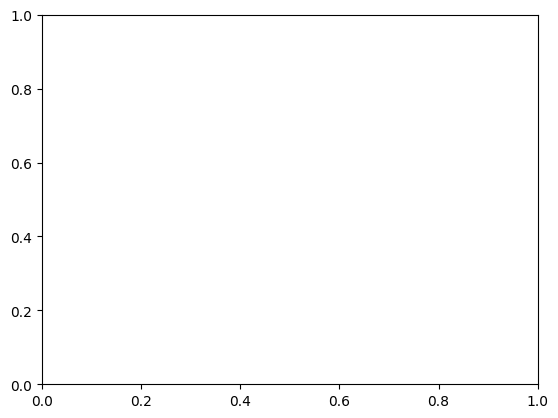

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
# create a figure and an axis object
fig, ax = plt.subplots()
# plot a heatmap of the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
# set the axis labels and title
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion matrix")
# show the plot
plt.show()



In [ ]:
import torchvision.transforms as transforms
from PIL import Image

# Define a transform function to resize and normalize the images
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Set the model to evaluation mode and move it to the GPU
model.eval()
model = model.to("cuda")  # Move the model to the GPU

with torch.no_grad():
    # Create an empty feature matrix with shape (number of training images, 1000)
    features = torch.zeros((len(training_images), 1000)).to("cuda")  # Move the tensor to the GPU
    # Loop through the training images and extract features
    for i, image_name in enumerate(training_images):
        # Load the image from the JPEGImages folder
        image = Image.open(f"/content/drive/MyDrive/surya/DL_Assignment/Fractal-1_Assignment-1/VOC2011/TrainVal/VOCdevkit/VOC2011/JPEGImages/{image_name}.jpg")
        # Apply the transform function to the image
        image = transform(image)
        # Add a batch dimension to the image tensor
        image = image.unsqueeze(0)
        # Move the image tensor to the GPU
        image = image.to("cuda")
        # Pass the image through the model and get the output of the last fully-connected layer
        output = model(image)
        # Store the output in the feature matrix
        features[i] = output.cpu()  # Move the output back to the CPU if needed
